In [ ]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
from jax import grad, value_and_grad
from plotting import plotx
from grid_utils import identity_mapping
import similarity
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, zoom
from plotting import show_warp_field
import numpy as np
import SimpleITK as sitk
import copy
import nibabel as nib

ModuleNotFoundError: ignored

In [ ]:


def get_warp_field(disp):
    nd, w, h = disp.shape
    id_map = identity_mapping((w, h))
    def_map = id_map + disp
    return def_map[::-1, :, :]

def compose_displacement_fields_sitk(d1, d2, spacing):
    """
    composition of the field phi with the new displacement field 
    """
    spacing = [spacing, spacing]
    ndim, w, h = d1.shape
    
    d1_sitk = _format_field_for_sitk_np(d1)
    d2_sitk = _format_field_for_sitk_np(d2)
    
    d1_sitk = sitk.GetImageFromArray(d1_sitk, isVector = True)
    d1_sitk.SetSpacing(spacing)
    
    d1_sitk.SetOrigin((0, 0))
    
    d2_sitk = sitk.GetImageFromArray(d2_sitk, isVector=True)
    d2_sitk.SetOrigin((0, 0))
    d2_sitk.SetSpacing(spacing)
    
    d1_sitk_tx = sitk.DisplacementFieldTransform(d1_sitk)
    d2_sitk_tx = sitk.DisplacementFieldTransform(d2_sitk)
    compose = sitk.CompositeTransform([d1_sitk_tx, d2_sitk_tx])
    composite_disp = sitk.TransformToDisplacementField(compose, size=(w, h), outputOrigin=(0, 0), outputSpacing= spacing)
    composed = sitk.GetArrayFromImage(composite_disp)
    composed = _format_field_for_jax(composed)
    
    return composed


def invert_displacement_field_sitk(disp_field, spacing):
    """
    inverts the displacement field using a fixed point iterative scheme
    right now boundary condition is not being enforced can be done by changing
    the filter being used for inversion 
    """
    ndim, w, h = disp_field.shape
    disp_f = np.zeros((w, h, ndim))
    spacing = (spacing, spacing)
    for i in range(ndim):
        disp_f[..., i] = disp_field[i, ...]
        
    disp_f = disp_f.astype(float)
    field = sitk.GetImageFromArray(disp_f, isVector=True)
    field.SetSpacing(spacing)
    field.SetOrigin((0, 0))
    
    inverse = sitk.InvertDisplacementField(field, maximumNumberOfIterations=1000,
    maxErrorToleranceThreshold=0.001,
    meanErrorToleranceThreshold=0.0001,
    enforceBoundaryCondition=True)
    
    field_inv =  _format_field_for_jax(sitk.GetArrayViewFromImage(inverse))
    return field_inv



def downsample_image(fix, shrink_factor, smoothing_sigma):
    zoom_factor = 1. / shrink_factor
    fix_smooth = gaussian_filter(fix, smoothing_sigma)
    im_res = zoom(fix_smooth, zoom_factor, order = 3, mode = "reflect")
    return im_res

def expand_displacement_field(phi, zoom_factor, order = 3, mode = "nearest"):
    
    ndim, _,_ = phi.shape
    return jnp.asarray([zoom(phi[i, ...], zoom_factor, order=order, mode=mode)
                    for i in range(ndim)])


def _format_field_for_sitk_np(field):
    ndim, w, h = field.shape
    sitk_field  = np.zeros((w, h, ndim))
    for i in range(ndim):
        sitk_field[..., i] = field[i, ...]
    sitk_field = sitk_field.astype(float)
    return sitk_field

def _format_field_for_jax(sitk_field):
    w, h, ndim = sitk_field.shape
    jax_field = np.zeros((ndim, w, h))
    for i in range(ndim):
        jax_field[i, ...] = sitk_field[..., i]
    return jax_field

def smooth(field, sigma = 2.):
    ndim, w, h = field.shape
    field_smoothed = np.zeros((ndim, w, h))
    for i in range(ndim):
        field_smoothed[i, ...] = gaussian_filter(field[i, ...], sigma)
    return field_smoothed 

def warp_image_with_displacement_field_sitk(im, disp_field):
    
    disp_field = _format_field_for_sitk_np(disp_field)
    disp_field = sitk.GetImageFromArray(disp_field, isVector=True)
    im = sitk.GetImageFromArray(im)
    
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(im)
    disp_tx = sitk.DisplacementFieldTransform(sitk.Cast(disp_field,sitk.sitkVectorFloat64))
    resampler.SetTransform(disp_tx)
    out = sitk.GetArrayFromImage(resampler.Execute(im))
    return out

def normalize_steps(gradient, step_size, spacing):
    
    gradient = gradient/spacing
    scale = step_size / jnp.linalg.norm(gradient, axis=-1).max()
    return scale

def set_bc(gradient):
    gradient = gradient.at[:, :, :1].set(0.)
    gradient = gradient.at[:, :, -2:].set(0.)
    gradient = gradient.at[:, :1, :].set(0.)
    gradient = gradient.at[:, -2:, :].set(0.)
    return gradient

def warp_image_with_displacement_field_jax(im, disp_field, spacing):
    
    """
    here can do one better instead of reassignment do a thing with jax.roll or swapaxes or somehting 
    so im doing somehting like function in and function out 
    
    """
    
    ix, iy = identity_mapping(im.shape)
    dx, dy = disp_field
    dix, diy = ix + dx , iy + dy
    
    return jax.scipy.ndimage.map_coordinates(im, jnp.asarray([diy, dix]), order = 1)

def warp_image_with_displacement_field_jax_pure(im, disp_field, spacing):
    
    """
    here im switching the channel ordering in a pure way just have to make sure that 
    it is differentiable 
    """
    
    id_map = identity_mapping(im.shape)
    def_map = id_map + disp_field #/ spacing
    
    
    return jax.scipy.ndimage.map_coordinates(im, def_map[::-1, :, :], order = 1)
    
def get_loss_fn(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing):
    
    sh = fix_level.shape
    id_map = identity_mapping(sh)
    
    def_map_fix_to_middle = id_map + disp_fix_to_middle #/ spacing
    def_map_mov_to_middle = id_map + disp_mov_to_middle #/ spacing
    
    fix_to_middle = jax.scipy.ndimage.map_coordinates(fix_level, def_map_fix_to_middle[::-1, :, :], order = 1)
    mov_to_middle = jax.scipy.ndimage.map_coordinates(mov_level, def_map_mov_to_middle[::-1, :, :], order = 1)
    
    loss = (1/.5)**2*similarity.ssd(fix_to_middle, mov_to_middle)
    return loss

def value_and_grad_fun(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing):
    
    sh = fix_level.shape
    w, h = sh
    id_map = identity_mapping(sh)
    
    def_map_fix_to_middle = id_map + disp_fix_to_middle #/ spacing
    def_map_mov_to_middle = id_map + disp_mov_to_middle #/ spacing
    
    fix_to_middle = jax.scipy.ndimage.map_coordinates(fix_level, def_map_fix_to_middle[::-1, :, :], order = 1)
    mov_to_middle = jax.scipy.ndimage.map_coordinates(mov_level, def_map_mov_to_middle[::-1, :, :], order = 1)
    
    loss = (1/.05)**2*jnp.sum((fix_to_middle - mov_to_middle)**2)
    
    
    df2m_grad =  jnp.asarray(jnp.gradient(fix_to_middle, spacing))
    dm2m_grad =  jnp.asarray(jnp.gradient(mov_to_middle, spacing))
    
    
    grad_fix_to_middle = 2*(1/.05)**2 * (fix_to_middle - mov_to_middle) * df2m_grad[::-1, :,:]
    grad_mov_to_middle =  2*(1/.05)**2 * (-fix_to_middle + mov_to_middle) * dm2m_grad[::-1,:,:]
    return loss, grad_fix_to_middle, grad_mov_to_middle
    

#value_and_grad_fun = value_and_grad(get_loss_fn, argnums = (2, 3))

In [ ]:
fix = jnp.asarray(nib.load("/Users/ranjak/Downloads/circle.nii").dataobj)
mov = jnp.asarray(nib.load("/Users/ranjak/Downloads/square.nii").dataobj)

In [ ]:
step_size = .25
num_levels = 3
num_iterations = [ 200, 100, 100]
smoothing_sigmas = [ 0.6, 0.2, 0.]
shrink_factors = [ 4, 2, 1]
spacings = shrink_factors


In [ ]:
## define the kernel for computing the lncc 
kernel_cc = similarity._get_lcc_loss_kernel(3)
lncc = partial(similarity._lcc_loss_2d_kernels, kernel = kernel_cc)

## SyN Algorithm

**For each level of the gaussian pyramid**

**1. If not initialized yet -**

       1. Initialize a displacement field fix_to_middle and mov_to_middle and expand to current shape
       If the displacement field has been initialized this step carries it forward to the next step
       
**2. Dowsample fix and moving images to the current resolution and smoothing of the gaussian pyramid**

**3. For each level run the opitmization iterations ---**

       1. warp the fix and moving to the middle using respective displacement transform
       2. compute the loss and gradient wrt to the displacement field (using autodiff) -- needs a fix for now i am doing an analytical gradient 
       3. set bc condition i.e. set displacement gradient at boundaries to be 0
       4. set the step_size of gradient descent update to be step_size = step_size / (grad / spacing).norm().max()
       5. update the displacement field as field = field - step_size * (smooth_gaussian_filter(grads)) for both fields
       6. monitor loss and convergence
       
**4. At the end of this level**

       1. Compute inverse of the displacement moving to middle, and fix to middle (use sitk.InvertDisplacementField)
       2. The full mapping is now given by moving to middle $\circ$ middle to fix and vice versa 
       
       

  0%|          | 0/200 [00:00<?, ?it/s]

4.082449e-07 2.9342215e-07


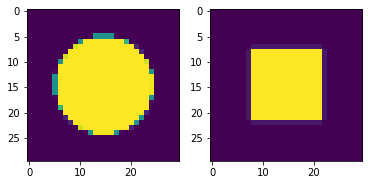

2250424800.0 72.32465 66.35982


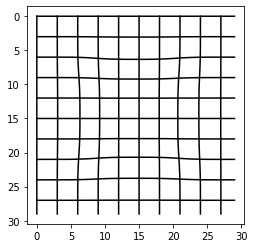

  0%|          | 1/200 [00:00<01:00,  3.29it/s]

6.1325153e-07 5.0255017e-07
6.081099e-07 6.709133e-07


  6%|▌         | 11/200 [00:00<00:06, 27.60it/s]

1.8567936e-06 1.8785968e-06
1.3506631e-06 1.2873156e-06
1.4188337e-06 1.3318086e-06
7.3814147e-07 7.201716e-07
1.6317175e-06 1.5592515e-06
6.4385e-07 6.814124e-07
2.0401933e-06 2.0440941e-06
6.3593274e-07 6.7427965e-07
2.1984233e-06 2.196305e-06
6.1233163e-07 6.5009635e-07


 10%|█         | 21/200 [00:00<00:04, 38.55it/s]

2.6887792e-06 2.6122366e-06
5.993155e-07 6.3384743e-07
3.0271228e-06 2.9400885e-06
5.9281126e-07 6.2133927e-07
3.3112187e-06 3.2090313e-06
5.9584914e-07 6.2089816e-07
3.1148954e-06 3.085493e-06
6.1361317e-07 6.308854e-07
2.863921e-06 2.839143e-06
6.1757316e-07 6.3620865e-07


 16%|█▌        | 31/200 [00:00<00:03, 43.80it/s]

2.7083793e-06 2.6925413e-06
6.336067e-07 6.4883073e-07
2.5597249e-06 2.5450088e-06
6.344461e-07 6.5177215e-07
2.460795e-06 2.4514516e-06
6.50355e-07 6.644872e-07
2.3722448e-06 2.3639761e-06
6.5256745e-07 6.687258e-07
2.2913027e-06 2.2860954e-06
6.6827914e-07 6.822049e-07


 20%|██        | 41/200 [00:01<00:03, 45.43it/s]

2.2208312e-06 2.2165573e-06
6.7247475e-07 6.8778803e-07
2.1531814e-06 2.149404e-06
6.838592e-07 6.9789945e-07
2.1073693e-06 2.1044357e-06
6.890884e-07 7.037093e-07
2.060736e-06 2.0584725e-06
6.97541e-07 7.116072e-07
2.0229336e-06 2.021593e-06
7.0379974e-07 7.179404e-07


 26%|██▌       | 51/200 [00:01<00:03, 46.54it/s]

1.9857555e-06 1.9852037e-06
7.110596e-07 7.2490434e-07
1.9527572e-06 1.953022e-06
7.176243e-07 7.313206e-07
1.9219217e-06 1.9230283e-06
7.2455003e-07 7.379907e-07
1.8906629e-06 1.8925404e-06
7.321053e-07 7.4488133e-07
1.8575621e-06 1.8599746e-06
7.3998575e-07 7.52081e-07


 30%|███       | 61/200 [00:01<00:02, 46.77it/s]

1.8254732e-06 1.8280831e-06
7.476248e-07 7.5905325e-07
1.796665e-06 1.799304e-06
7.5478584e-07 7.655985e-07
1.7709759e-06 1.7736596e-06
7.616895e-07 7.720495e-07
1.7452611e-06 1.7480081e-06
7.690572e-07 7.7896584e-07
1.7197882e-06 1.7225823e-06
7.7649145e-07 7.8600107e-07


 36%|███▌      | 71/200 [00:01<00:02, 47.54it/s]

1.6948177e-06 1.6976425e-06
7.839869e-07 7.931348e-07
1.6749489e-06 1.677809e-06
7.90415e-07 7.9931874e-07
1.6609395e-06 1.6638065e-06
7.95628e-07 8.043282e-07
1.6519981e-06 1.6548706e-06
7.997389e-07 8.082584e-07
1.6472817e-06 1.6501834e-06
8.029075e-07 8.1127325e-07


 40%|████      | 81/200 [00:01<00:02, 48.10it/s]

1.6457768e-06 1.6487338e-06
8.053719e-07 8.136018e-07
1.6466421e-06 1.6496774e-06
8.0731e-07 8.154361e-07
1.6490178e-06 1.6521449e-06
8.0870404e-07 8.1676677e-07
1.6517198e-06 1.654924e-06
8.0929243e-07 8.1733174e-07
1.6537266e-06 1.6570638e-06
8.0982386e-07 8.177699e-07


 46%|████▌     | 91/200 [00:02<00:02, 47.75it/s]

1.6546887e-06 1.6581544e-06
8.109451e-07 8.185375e-07
1.6543319e-06 1.6579214e-06
8.127857e-07 8.199178e-07
1.6532351e-06 1.6569461e-06
8.1513684e-07 8.217598e-07
1.6518769e-06 1.6557082e-06
8.177239e-07 8.2383133e-07
1.6504342e-06 1.6543817e-06
8.201199e-07 8.2577293e-07


 48%|████▊     | 96/200 [00:02<00:02, 47.00it/s]

1.6484925e-06 1.6524789e-06
8.2173506e-07 8.2703576e-07
1.6467836e-06 1.6507857e-06
8.232941e-07 8.282651e-07
1.6452095e-06 1.6492291e-06
8.251063e-07 8.297282e-07
1.6438346e-06 1.6478739e-06
8.289999e-07 8.328919e-07


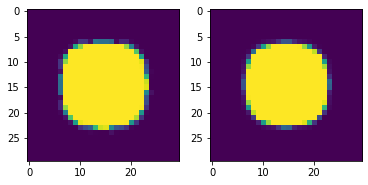

175911120.0 63.95909 63.009254


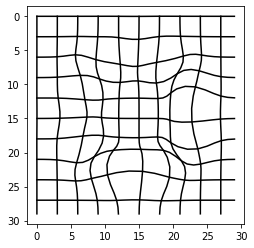

 50%|█████     | 101/200 [00:02<00:03, 27.07it/s]

1.6442802e-06 1.6483226e-06
8.3090407e-07 8.342215e-07


 56%|█████▌    | 111/200 [00:02<00:02, 34.99it/s]

1.648739e-06 1.652926e-06
8.3223574e-07 8.3502295e-07
1.654976e-06 1.6593698e-06
8.334306e-07 8.357135e-07
1.661929e-06 1.6665741e-06
8.3472673e-07 8.365338e-07
1.6688066e-06 1.6737057e-06
8.3571183e-07 8.3714275e-07
1.675404e-06 1.6805043e-06
8.366811e-07 8.3768094e-07


 60%|██████    | 121/200 [00:03<00:01, 40.65it/s]

1.6877863e-06 1.693299e-06
8.3744345e-07 8.3804e-07
1.7027223e-06 1.708699e-06
8.385826e-07 8.3886204e-07
1.7190414e-06 1.7251501e-06
8.391654e-07 8.391898e-07
1.7384722e-06 1.7445859e-06
8.3896697e-07 8.3875005e-07
1.761151e-06 1.7672656e-06
8.3825915e-07 8.378094e-07


 66%|██████▌   | 131/200 [00:03<00:01, 44.12it/s]

1.786271e-06 1.7923832e-06
8.3721835e-07 8.36564e-07
1.813204e-06 1.8193092e-06
8.3596996e-07 8.351495e-07
1.8407111e-06 1.8467633e-06
8.341316e-07 8.3323533e-07
1.86806e-06 1.8740174e-06
8.319986e-07 8.3105346e-07
1.8943762e-06 1.9002138e-06
8.2997013e-07 8.2896986e-07


 70%|███████   | 141/200 [00:03<00:01, 46.52it/s]

1.9177685e-06 1.923447e-06
8.289274e-07 8.27857e-07
1.9383392e-06 1.9438476e-06
8.286995e-07 8.275658e-07
1.9559766e-06 1.9613826e-06
8.292348e-07 8.2802643e-07
1.9711524e-06 1.9764816e-06
8.3031534e-07 8.2903347e-07
1.984331e-06 1.9895685e-06
8.320181e-07 8.30667e-07
1.9953068e-06 2.0004388e-06


 76%|███████▌  | 151/200 [00:03<00:01, 47.29it/s]

8.342809e-07 8.328697e-07
2.0033542e-06 2.008349e-06
8.3706817e-07 8.3561685e-07
2.0036439e-06 2.0083094e-06
8.3997327e-07 8.385145e-07
2.0007344e-06 2.0050354e-06
8.4365877e-07 8.42174e-07
1.9950726e-06 1.998996e-06
8.483009e-07 8.46753e-07
1.9872743e-06 1.990815e-06


 80%|████████  | 161/200 [00:03<00:00, 47.65it/s]

8.5332044e-07 8.5171854e-07
1.977662e-06 1.9808112e-06
8.5866435e-07 8.570199e-07
1.9665272e-06 1.9692777e-06
8.6429594e-07 8.626218e-07
1.951452e-06 1.9537595e-06
8.692085e-07 8.675517e-07
1.9343092e-06 1.936167e-06
8.72948e-07 8.7136107e-07
1.9136837e-06 1.915134e-06


 86%|████████▌ | 171/200 [00:04<00:00, 48.00it/s]

8.794628e-07 8.7769564e-07
1.8991501e-06 1.9002921e-06
8.8206116e-07 8.8023495e-07
1.8948475e-06 1.8958234e-06
8.8244843e-07 8.8063297e-07
1.8984504e-06 1.8994456e-06
8.8074233e-07 8.7903766e-07
1.9096917e-06 1.9109182e-06
8.785471e-07 8.7703046e-07
1.9233323e-06 1.9248491e-06


 90%|█████████ | 181/200 [00:04<00:00, 48.23it/s]

8.768322e-07 8.7548165e-07
1.9362783e-06 1.938146e-06
8.797256e-07 8.782015e-07
1.9430709e-06 1.9450483e-06
8.846045e-07 8.828495e-07
1.944611e-06 1.9465544e-06
8.8975384e-07 8.8790483e-07
1.9423367e-06 1.9442105e-06
8.946575e-07 8.9280917e-07
1.9353224e-06 1.9371187e-06


 96%|█████████▌| 191/200 [00:04<00:00, 48.64it/s]

8.9922463e-07 8.9741775e-07
1.9255492e-06 1.9272745e-06
9.0335527e-07 9.016125e-07
1.9147678e-06 1.9164743e-06
9.066823e-07 9.050183e-07
1.9050996e-06 1.9068923e-06
9.1080113e-07 9.0920076e-07
1.8960422e-06 1.8979911e-06
9.1476005e-07 9.132165e-07
1.886415e-06 1.8885904e-06


100%|██████████| 200/200 [00:04<00:00, 42.43it/s]


9.180097e-07 9.1651094e-07
1.8798889e-06 1.8824318e-06
9.1971714e-07 9.1829145e-07
1.8760649e-06 1.8791108e-06
9.2241186e-07 9.2116113e-07
1.8581031e-06 1.8610933e-06


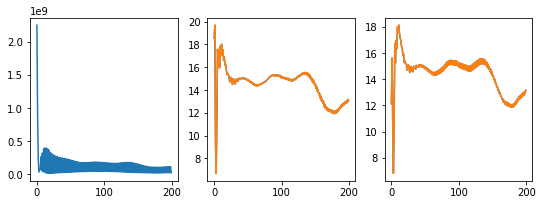

  0%|          | 0/100 [00:00<?, ?it/s]

8.503754e-08 5.8946817e-08


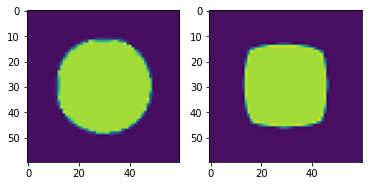

3398553600.0 19.386147 19.799618


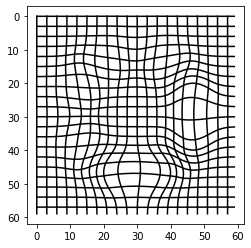

 11%|█         | 11/100 [00:00<00:03, 24.98it/s]

9.4477635e-08 6.179413e-08
9.872575e-08 7.236204e-08
9.756969e-08 9.6695764e-08
8.985343e-08 8.907502e-08
1.14374224e-07 1.11010074e-07
1.998007e-07 1.9200124e-07
4.1224544e-07 3.570181e-07
4.1179538e-07 3.5302853e-07
4.4528417e-07 3.855067e-07
4.1858954e-07 3.6119485e-07


 21%|██        | 21/100 [00:00<00:02, 36.20it/s]

4.5732205e-07 4.0044213e-07
4.3555193e-07 3.8189992e-07
5.0083406e-07 4.4702173e-07
4.2835e-07 3.8190407e-07
5.2951685e-07 4.8458656e-07
3.3660638e-07 3.143367e-07
4.7708113e-07 4.394941e-07
2.9285025e-07 2.8466945e-07
4.621082e-07 4.2606635e-07
2.9204355e-07 2.8726208e-07


 31%|███       | 31/100 [00:01<00:01, 42.07it/s]

4.457548e-07 4.09617e-07
2.9123774e-07 2.8893717e-07
4.338643e-07 3.9664104e-07
2.9108526e-07 2.9043332e-07
4.2335753e-07 3.8480835e-07
2.9235648e-07 2.9254107e-07
4.127643e-07 3.7325174e-07
2.9591212e-07 2.9604084e-07
4.0211583e-07 3.627231e-07
3.0065226e-07 3.0018813e-07


 41%|████      | 41/100 [00:01<00:01, 45.28it/s]

3.912177e-07 3.5216638e-07
3.0639507e-07 3.049553e-07
3.803608e-07 3.4181124e-07
3.127715e-07 3.1009856e-07
3.6925044e-07 3.3149792e-07
3.1998368e-07 3.1584997e-07
3.5865116e-07 3.219291e-07
3.2796365e-07 3.2219762e-07
3.4967374e-07 3.1380154e-07
3.3580238e-07 3.2852992e-07


 51%|█████     | 51/100 [00:01<00:01, 46.39it/s]

3.429558e-07 3.0792762e-07
3.4359974e-07 3.3469547e-07
3.375949e-07 3.0350904e-07
3.511448e-07 3.405647e-07
3.319321e-07 2.9894483e-07
3.570478e-07 3.44792e-07
3.2703775e-07 2.9523608e-07
3.6088474e-07 3.4729442e-07
3.2277092e-07 2.921222e-07
3.6417896e-07 3.4958842e-07


 61%|██████    | 61/100 [00:01<00:00, 47.21it/s]

3.1867776e-07 2.889612e-07
3.6807384e-07 3.526802e-07
3.1425924e-07 2.852996e-07
3.7350003e-07 3.5735903e-07
3.097564e-07 2.812983e-07
3.8052377e-07 3.636809e-07
3.050474e-07 2.769119e-07
3.892655e-07 3.7165887e-07
2.9991688e-07 2.720917e-07
3.9978895e-07 3.8126444e-07


 71%|███████   | 71/100 [00:01<00:00, 47.79it/s]

2.9449234e-07 2.6703253e-07
4.1178072e-07 3.9219344e-07
2.889478e-07 2.6192728e-07
4.249081e-07 4.041567e-07
2.8342197e-07 2.56904e-07
4.3895818e-07 4.1698547e-07
2.7799848e-07 2.5203798e-07
4.535737e-07 4.3040882e-07
2.7268288e-07 2.4729238e-07
4.685791e-07 4.4422828e-07


 81%|████████  | 81/100 [00:02<00:00, 47.54it/s]

2.6773287e-07 2.4285794e-07
4.843079e-07 4.593986e-07
2.636099e-07 2.3894026e-07
4.9960374e-07 4.743097e-07
2.6016738e-07 2.355757e-07
5.140653e-07 4.8843697e-07
2.5722935e-07 2.3267101e-07
5.280311e-07 5.020541e-07
2.548031e-07 2.3026647e-07
5.4092106e-07 5.146602e-07


 91%|█████████ | 91/100 [00:02<00:00, 47.87it/s]

2.526392e-07 2.2818764e-07
5.5205606e-07 5.2553224e-07
2.509064e-07 2.2658425e-07
5.612228e-07 5.3459667e-07
2.5000912e-07 2.2576653e-07
5.670378e-07 5.4045086e-07
2.4917938e-07 2.2506981e-07
5.7232467e-07 5.457372e-07
2.4821944e-07 2.2428067e-07
5.7789094e-07 5.5130243e-07


100%|██████████| 100/100 [00:02<00:00, 40.85it/s]


2.474304e-07 2.234647e-07
5.8502263e-07 5.5844356e-07
2.462889e-07 2.2220252e-07
5.9531806e-07 5.6850075e-07
2.451468e-07 2.2094048e-07
6.063014e-07 5.792034e-07
2.439449e-07 2.1961651e-07
6.1898595e-07 5.913814e-07
2.4257767e-07 2.1810992e-07


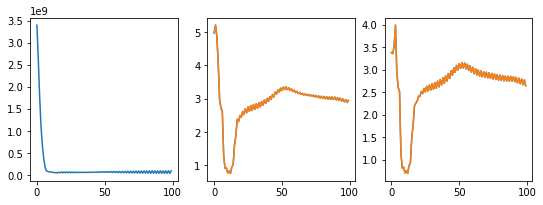

  0%|          | 0/100 [00:00<?, ?it/s]

1.7768485e-08 1.3033138e-08


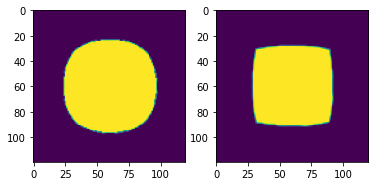

16662288000.0 5.7026134 4.91921


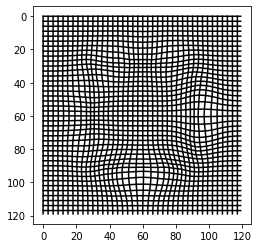

  6%|▌         | 6/100 [00:00<00:08, 11.32it/s]

1.7826027e-08 1.320165e-08
1.8431809e-08 1.355676e-08
1.8162678e-08 1.4084381e-08
1.8031471e-08 1.4866757e-08
1.7930828e-08 1.48519925e-08
1.7733528e-08 1.4646944e-08
1.733706e-08 1.4588833e-08
1.6741657e-08 1.4738482e-08
1.6060037e-08 1.4928654e-08
1.5358447e-08 1.4580659e-08


 16%|█▌        | 16/100 [00:00<00:03, 25.95it/s]

1.5019506e-08 1.44315235e-08
1.5159817e-08 1.4657402e-08
1.5338266e-08 1.5201747e-08
1.548743e-08 1.5933118e-08
1.6564282e-08 1.5130952e-08
1.7478012e-08 1.4138542e-08
1.76125e-08 1.3779705e-08
1.8252495e-08 1.3784117e-08
1.7739438e-08 1.4043739e-08
1.7306567e-08 1.4790481e-08


 26%|██▌       | 26/100 [00:01<00:02, 35.13it/s]

1.7630654e-08 1.475925e-08
1.8351152e-08 1.5218271e-08
1.9255046e-08 1.6559335e-08
1.8869384e-08 1.831468e-08
1.8555768e-08 2.0452308e-08
1.8209295e-08 2.0159499e-08
1.773275e-08 1.8474468e-08
1.7143568e-08 1.72432e-08
1.6839186e-08 1.6545036e-08
1.7256037e-08 1.6868047e-08


 36%|███▌      | 36/100 [00:01<00:01, 40.17it/s]

1.8110581e-08 1.791144e-08
1.9505505e-08 1.9448386e-08
2.1513618e-08 2.1520725e-08
2.421177e-08 2.4213355e-08
2.7623516e-08 2.7621628e-08
3.2023454e-08 3.201664e-08
3.7582897e-08 3.7569112e-08
4.444262e-08 4.4420343e-08
5.5897807e-08 5.5855224e-08
7.0902836e-08 7.0819596e-08


 51%|█████     | 51/100 [00:01<00:01, 44.12it/s]

8.127445e-08 8.115346e-08
8.645116e-08 8.6309086e-08
9.003511e-08 8.9878135e-08
9.2962864e-08 9.2794274e-08
9.5510224e-08 9.5332425e-08
9.781202e-08 9.7626774e-08
9.995623e-08 9.976479e-08
1.01995916e-07 1.017992e-07
1.03972035e-07 1.0377069e-07
1.0590838e-07 1.0570283e-07


 61%|██████    | 61/100 [00:01<00:00, 45.26it/s]

1.0784076e-07 1.0763127e-07
1.0986605e-07 1.0965219e-07
1.11887104e-07 1.11668975e-07
1.1391396e-07 1.1369163e-07
1.15951565e-07 1.1572505e-07
1.18002006e-07 1.1777135e-07
1.2006332e-07 1.1982854e-07
1.2214286e-07 1.2190401e-07
1.2423384e-07 1.2399089e-07
1.2634231e-07 1.2609532e-07


 66%|██████▌   | 66/100 [00:01<00:00, 45.21it/s]

1.2846239e-07 1.2821141e-07
1.3059407e-07 1.3033913e-07
1.3273677e-07 1.3247796e-07
1.3488736e-07 1.3462473e-07
1.370411e-07 1.3677479e-07
1.3920275e-07 1.3893283e-07
1.4136275e-07 1.4108937e-07
1.4351991e-07 1.4324323e-07
1.4567343e-07 1.453936e-07
1.478216e-07 1.4753876e-07


 76%|███████▌  | 76/100 [00:02<00:00, 45.26it/s]

1.4996141e-07 1.4967576e-07
1.5208657e-07 1.5179829e-07
1.5419347e-07 1.5390282e-07
1.5628828e-07 1.5599542e-07
1.5836146e-07 1.5806664e-07
1.6041056e-07 1.6011404e-07
1.6243693e-07 1.6213893e-07
1.6364807e-07 1.6382029e-07
1.6478282e-07 1.649595e-07
1.6590877e-07 1.6608895e-07


 86%|████████▌ | 86/100 [00:02<00:00, 45.57it/s]

1.6702151e-07 1.6720436e-07
1.6811822e-07 1.6830265e-07
1.6919573e-07 1.6938095e-07
1.7025567e-07 1.7044067e-07
1.712926e-07 1.7147632e-07
1.7239196e-07 1.7257364e-07
1.7357556e-07 1.7375476e-07
1.7474501e-07 1.7492081e-07
1.7590395e-07 1.7607537e-07
1.7705023e-07 1.7721659e-07


100%|██████████| 100/100 [00:02<00:00, 36.68it/s]


1.7818623e-07 1.7834674e-07
1.7930951e-07 1.7946334e-07
1.8051294e-07 1.8065231e-07
1.8174266e-07 1.8186834e-07
1.8295611e-07 1.8306757e-07
1.8416617e-07 1.8426388e-07
1.8535759e-07 1.854411e-07
1.8653985e-07 1.8660945e-07
1.8770758e-07 1.8776309e-07


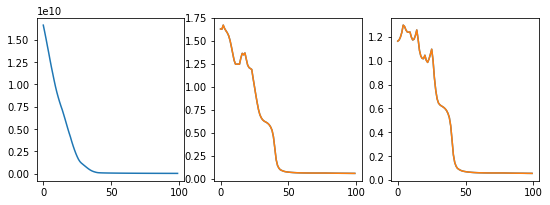

In [ ]:

disp_fix_to_middle = None
disp_mov_to_middle = None
for level, iterations  in enumerate(num_iterations):
    
    spacing = shrink_factors[level]
    
    step_size = 1.5
    
    flow_sigma = 2.
    
    ## downsample images to current resolution and smoothing
    fix_level = downsample_image(fix, shrink_factors[level], smoothing_sigmas[level])
    mov_level = downsample_image(mov, shrink_factors[level], smoothing_sigmas[level])
    
    
    ## declare the displacement fields for SyN 
    if disp_fix_to_middle is None and disp_mov_to_middle is None:
        disp_fix_to_middle = jnp.zeros((2, *fix_level.shape))
        disp_mov_to_middle = jnp.zeros((2, *mov_level.shape))
    else:
        #zoom to current resolution warp the images and get going 
        zoom_factor_phi = fix_level.shape[-1]/disp_fix_to_middle.shape[-1]
        disp_fix_to_middle = expand_displacement_field(disp_fix_to_middle, zoom_factor_phi)
        disp_mov_to_middle = expand_displacement_field(disp_mov_to_middle, zoom_factor_phi)
        
    ## smoothers right now is a naive gaussian smoother maybe in future fix this 
    iteration = 0
    converged = False
    losses = []
    grads_1 = []
    grads_2 = []
    for i in tqdm(range(iterations)):
    #while(iteration < iterations and not converged):

        fix_to_middle = warp_image_with_displacement_field_jax_pure(fix_level, disp_fix_to_middle, spacing)
        mov_to_middle = warp_image_with_displacement_field_jax_pure(mov_level, disp_mov_to_middle, spacing)
        
        
        
        ## compute the losses and gradients of the displacement fields 
        loss, grad_fix_to_middle, grad_mov_to_middle = value_and_grad_fun(fix_level, mov_level, disp_fix_to_middle, disp_mov_to_middle, spacing)
        
        losses.append(loss)
        
        grad_fix_to_middle = set_bc(grad_fix_to_middle)
        grad_mov_to_middle = set_bc(grad_mov_to_middle)
        
        ## normalize the gradients by their norm
        scale_fix_to_middle = normalize_steps(grad_fix_to_middle, step_size, spacing)
        scale_mov_to_middle = normalize_steps(grad_mov_to_middle, step_size, spacing)

        print (scale_fix_to_middle, scale_mov_to_middle)
        
        ## update the displacement fields 
        disp_fix_to_middle -= scale_fix_to_middle * smooth(grad_fix_to_middle, flow_sigma) 
        disp_mov_to_middle -= scale_mov_to_middle * smooth(grad_mov_to_middle, flow_sigma)
        
        grads_1.append(jnp.linalg.norm((scale_fix_to_middle * smooth(grad_fix_to_middle, flow_sigma)).reshape(2, -1), axis = -1))
        grads_2.append(jnp.linalg.norm((scale_mov_to_middle * smooth(grad_mov_to_middle, flow_sigma)).reshape(2, -1), axis = -1))
        
        if i %100 == 0:
            plotx(fix_to_middle, mov_to_middle)
            print (loss, scale_fix_to_middle*jnp.linalg.norm(grad_fix_to_middle), scale_fix_to_middle*jnp.linalg.norm(grad_mov_to_middle))

            show_warp_field(get_warp_field(disp_mov_to_middle), interval=3, shape = disp_mov_to_middle.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)
    
    f, a = plt.subplots(1, 3, figsize =(9, 3))
    a[0].plot(losses)
    a[1].plot(grads_1)
    a[2].plot(grads_2)
    plt.show()
    
    ## invert the displacement fields to go in the opposite direction 
    disp_middle_to_fix = invert_displacement_field_sitk(disp_fix_to_middle, spacing)
    disp_middle_to_mov = invert_displacement_field_sitk(disp_mov_to_middle, spacing)
    
    ## update the full displacement field by composing the two halves of the displacement fields 
    disp_fix_to_mov = compose_displacement_fields_sitk(disp_fix_to_middle, disp_middle_to_mov, spacing)
    disp_mov_to_fix = compose_displacement_fields_sitk(disp_mov_to_middle, disp_middle_to_fix, spacing)
    

In [ ]:
### deformation map for the moving to mid

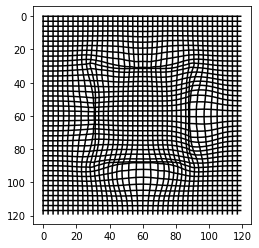

In [ ]:
show_warp_field(get_warp_field(disp_mov_to_middle[:,:,:] ), interval=3, shape = disp_mov_to_middle.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

In [ ]:
## deformation map for middle to fix

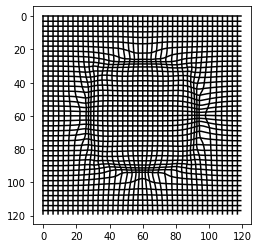

In [ ]:
show_warp_field(get_warp_field(disp_middle_to_fix[:,:,:] ), interval=3, shape = disp_middle_to_fix.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

In [ ]:
## deformation map for mov to fix

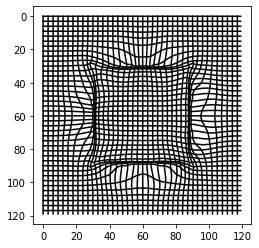

In [ ]:
show_warp_field(get_warp_field(disp_mov_to_fix[:,:,:] ), interval=3, shape = disp_mov_to_fix.shape[1:],
                    size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)

### first warp the images by the two halves 

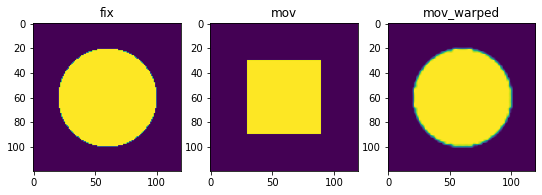

In [ ]:
warps = [disp_mov_to_middle, disp_middle_to_fix]
mov_w  = copy.deepcopy(mov)
for w in warps:
    mov_w = warp_image_with_displacement_field_jax(mov_w, w, 1)

titles = [ "fix", "mov", "mov_warped"]
f, a = plt.subplots(1, 3, figsize =(9, 3))
a[2].imshow(mov_w)
a[0].imshow(fix)
a[1].imshow(mov)
for i in range(3):
    a[i].set_title(titles[i])

## now warp by the composite field i.e. disp_mov_to_middle composed with disp_middle_to_fix

In [ ]:
mov_warped_by_composite = warp_image_with_displacement_field_jax(mov, disp_mov_to_fix, 1)

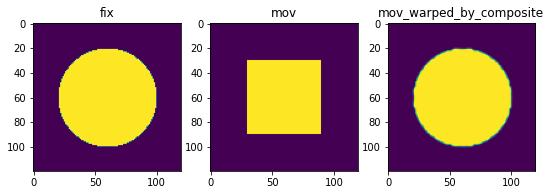

In [ ]:
titles = [ "fix", "mov", "mov_warped_by_composite"]
f, a = plt.subplots(1, 3, figsize =(9, 3))
a[2].imshow(mov_warped_by_composite)
a[0].imshow(fix)
a[1].imshow(mov)
for i in range(3):
    a[i].set_title(titles[i])